# timmを使用した転移学習モデル

### 参考URL→ https://zenn.dev/piment/articles/4ff3b6dfd73103

In [398]:
import timm
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn as nn
import os
import matplotlib.pyplot as plt

In [399]:
# timm.list_models(pretrained=True)

In [400]:
#in_chans=1でグレイスケール
model = timm.create_model('resnet18d',pretrained=True,num_classes = 2, in_chans = 1)
# model = timm.create_model('resnet18d', pretrained=True, num_classes = 2)

In [401]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
   

In [402]:
# freeze layers except last layer
for param in model.parameters():
    param.requires_grad = False

last_layer = list(model.children())[-2]
print(f'except last layer: {last_layer}')
for param in last_layer.parameters():
    param.requires_grad = True

except last layer: SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))


In [403]:
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
   

In [404]:
#追加する層
net_seq=nn.Sequential(
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=True),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True)
)

In [405]:
# net_seq

In [406]:
#層を追加
# model.add_module('layer5', nn.Identity())
# model.layer5 = nn.Sequential(net_seq, model.layer5)
model.layer4.add_module('add_layer', net_seq)
# model.layer4 = nn.Sequential(net_seq, model.layer4)

In [407]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
   

# 学習させる画像 https://cgpipeliner.info/2022/04/29/cnn-datalorder/#st-toc-h-3

In [408]:
for i in os.listdir('cut_roundeye/'):
    print(i)

nmirror
mirror


# trainデータを作成した後、7割をtrain, 3割をvalに分けてDataLoaderとする

In [409]:
# import torch
# import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
# import pytorch_lightning as pl

#シード値の固定
# pl.seed_everything(0)

# 学習データのパス
data_path = 'new_TrainDataset'

# バッチサイズ
batch_size = 1024

# オーグメンテーション
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
#     """Convert a color image to grayscale and normalize the color range to [0,1]."""
])

# データセットの作成
dataset = datasets.ImageFolder(data_path, transform)


# 学習データに使用する割合
n_train_ratio = 70

# 割合から個数を出す
n_train = int(len(dataset) * n_train_ratio / 100)
n_val   = int(len(dataset) - n_train)


# 学習データと検証データに分割
train, val = torch.utils.data.random_split(dataset, [n_train, n_val])

# 
# Data Loader
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)

# train_loaderの中身確認

In [410]:
count = 0
for data in train_loader:
    count+=1

In [411]:
count

15

In [412]:
print('データローダのタイプ', type(train_loader))
print('全体のデータ量 : ',len(dataset))
print('イテレーション : ', len(train_loader))

データローダのタイプ <class 'torch.utils.data.dataloader.DataLoader'>
全体のデータ量 :  22769
イテレーション :  15


### 画像とラベルを取り出す

In [413]:
# データロダからバッチを取り出す
image_list, label_list = next(iter(train_loader))

print('画像の枚数   : ', len(image_list))
print('ラベルの個数 : ', len(label_list))
print('画像        : ', image_list[0].shape)
print('ラベル      : ', label_list[0])

画像の枚数   :  1024
ラベルの個数 :  1024
画像        :  torch.Size([1, 64, 64])
ラベル      :  tensor(1)


# 学習　参考→ https://htomblog.com/pthon-timm

In [434]:
from timm.utils import AverageMeter
from tqdm import tqdm

# 最適化手法
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

# 損失関数
criterion = torch.nn.CrossEntropyLoss()

# ログ記録用の変数
history = {"train": [], "test": []}

# 学習回数
for epoch in range(30):
    print("\nEpoch:", epoch)

    # 学習
    model.train()
    train_loss = AverageMeter()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        image = batch[0] #(batch_size, channel, size, size)
        label = batch[1] #(batch_size)
#         preds = model(image) #(batch_size, num_class)
        preds = model(image)
        loss = criterion(preds, label)
        loss.backward() #誤差逆伝播
        optimizer.step() #学習
        train_loss.update(val = loss.item(), n = len(image))


    # 検証
    model.eval()
    test_loss = AverageMeter()
    with torch.no_grad():
        for batch in tqdm(val_loader):
            image = batch[0] #(batch_size, channel, size, size)
            label = batch[1] #(batch_size)
            preds = model(image) #(batch_size, num_class)
            loss = criterion(preds, label)
            test_loss.update(val = loss.item(), n = len(image))


    # 誤差出力
    print(train_loss.avg)
    print(test_loss.avg)
    history["train"].append(train_loss.avg)
    history["test"].append(test_loss.avg)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0


  0%|          | 0/15 [00:01<?, ?it/s]


KeyError: 'train_loss'

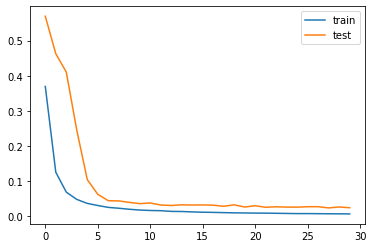

In [415]:
plt.plot(history["train"], label = "train")
plt.plot(history["test"], label = "test")
plt.legend()
plt.show()

# test画像

In [416]:

# 学習データのパス
test_path = 'new_TestDataset'

# バッチサイズ
batch_size = 256

# オーグメンテーション
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# データセットの作成
test_dataset = datasets.ImageFolder(test_path, transform)

# Data Loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)

In [417]:
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(data_path[0][0].permute(1, 2, 0))
# plt.title(train_loader[1][1])
# plt.subplot(1, 2, 2)
# plt.imshow(test_loader[0][0].permute(1, 2, 0))
# plt.title(test_loader[1][1])
# plt.show()

In [418]:
import mediapipe

model.eval()
preds = []
labels = []

mp_drawing = mediapipe.solutions.drawing_utils
mp_drawing_styles = mediapipe.solutions.drawing_styles
mp_face_mesh = mediapipe.solutions.face_mesh

with torch.no_grad():
    for batch in tqdm(test_loader):
        image = batch[0]
        label = batch[1]


        # 最も値の大きい列番号
        preds += model(image).numpy().argmax(axis = 1).tolist()
#         print(preds)
        # 答え
        labels += label.numpy().tolist()

100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


In [419]:
print(preds[:5])
print(labels[:5])

[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


In [420]:
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, preds))

0.7226836371480962


In [421]:
# torch.save(model.state_dict(), 'model_resnet50_pre50.pth')
# torch.save(model, 'model_resnet50_pre50.pth')
torch.save(model.state_dict(), 'model_resnet18d_NoFrop_3_new_TrainDataset.pth')

In [422]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_pre = confusion_matrix(labels, preds)

Text(0.5, 15.0, 'predictions')

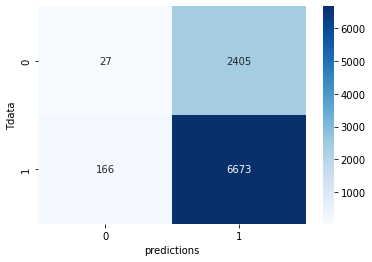

In [423]:
#fmt='d'で数字の指数表記をなくせる
sns.heatmap(cm_pre, annot=True, cmap='Blues', fmt='d')
plt.ylabel('Tdata')
plt.xlabel('predictions')
# plt.title(path)